### 12 Jan 2023

# Fig. 3 code.

In [1]:
# # load packages
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from pyhdf.SD import SD, SDC
import cmocean
import scipy
from scipy import ndimage
import cartopy.crs as ccrs
import cartopy
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
import numpy as np
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
import rasterio
from rasterio.plot import show
import pyproj
from pyproj import Proj, transform, CRS

/opt/anaconda3/envs/sealenv/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
pyproj.datadir.get_data_dir()

'/opt/anaconda3/share/proj'

In [3]:
# need this line for pyproj to work on my machine
pyproj.datadir.set_data_dir('/opt/anaconda3/envs/sealenv/share/proj') 

## A. MODIS image

### 1. Read in 2019 seal data

In [4]:
# read data
seal19 = pd.read_pickle('seal19_file')
seal19.head(2)

,LATITUDE,LONGITUDE,Temperature [C],Salinity [PSU],z,SA,CT,PT,PD,N2,Datetime,Station
0.0,-73.664004,-103.15514,-0.323368,33.512524,0.000000,33.673292,-0.317368,-0.323368,26.924812,NaN,2019-02-12 22:59:59.999971200,ct147-867-18_prof
1.0,-73.664004,-103.15514,-0.323368,33.512524,0.989675,33.673276,-0.317398,-0.323397,26.924801,-1.101809e-07,2019-02-12 22:59:59.999971200,ct147-867-18_prof


In [5]:
# isolate bgd/cool profiles within bounds on pink dashed box from Fig. 1
coolsurf = seal19[['z','Datetime','LATITUDE', 'LONGITUDE','SA','Temperature [C]','CT','PD']].query('-74.9 < LATITUDE < -74 & -104.7 < LONGITUDE < -102 & 0.0 <= z <= 20')
coolsurfMJJA19 = coolsurf[(coolsurf['Datetime']>='2019-5-1') & (coolsurf['Datetime']<'2019-9-1')] #constrain dates

define cutoff T of warm vs. bdg profiles 
thresh2014 = coolsurfMJJA19['CT'].mean() + 3*coolsurfMJJA19['CT'].std()
print(thresh2014)

### 2. Here, only want May 2019 dives, so isolate those

In [6]:
# constrain dates
may19 = seal19[(seal19['Datetime']>='2019-5-1') & (seal19['Datetime']<'2019-9-1')]

# constrain bounds (now orange dashed box in Fig. 1 -- that is study area of interest)
may19 = may19[['z','Datetime','LATITUDE', 'LONGITUDE','SA','Temperature [C]','CT','PD']].query('-75.25 < LATITUDE < -74.5 & -104 < LONGITUDE < -100 & 0 <= z <= 20')

In [7]:
# isolate specific date
may25_2019 = may19[may19['Datetime'].dt.strftime('%Y-%m-%d') == '2019-05-25']
#may25_2019.count()

# keep only surface value
may25_2019 = may25_2019[(may25_2019 ['z']==0.0)]
#may25_2019.count()

In [8]:
# Grid data for plotting 
data1 = may25_2019
data = data1.groupby('Datetime').mean()
data['Max z'] = (data1.groupby('Datetime').max())['z']
vbl = 'CT'
data = data[data[vbl].notna()]
y = data['LATITUDE']
x = data['LONGITUDE']
z = data[vbl]

In [9]:
# define colormap for seal data so that is shows up on thermal image
sealcmap = plt.cm.get_cmap('YlGn') 
sealcmap = sealcmap.reversed()

### 2. Read in coicident thermal image (25 May 2019)

In [21]:
# Make list of all MOD09 files in folder
MODfiles = glob('../MODIS/2019/MOD09.A2019145.1625.006.2019147020537.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)
B31 = (mod09.select('BAND31')[:]/100)-273.15
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

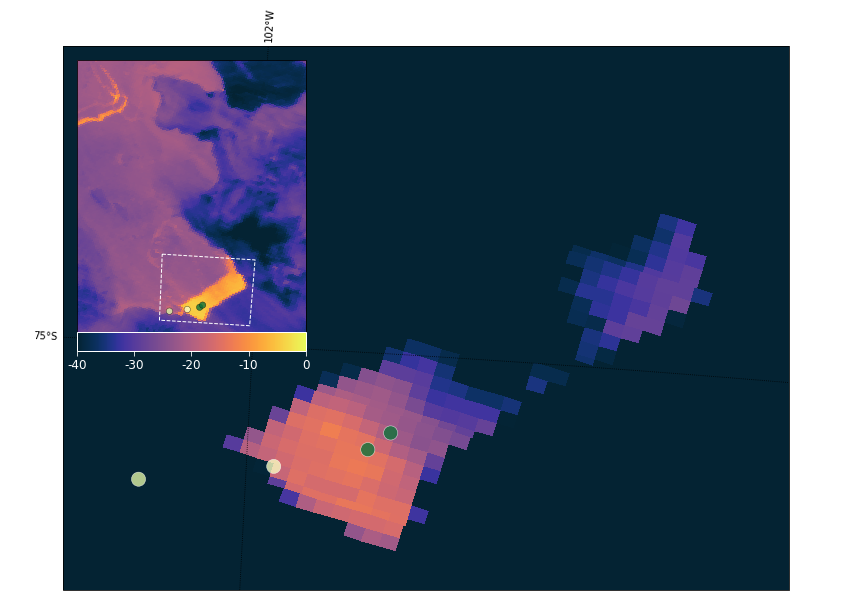

In [22]:
if vbl=='SA': vmin = 33.8;vmax=34.3
elif vbl=='PD': vmin = 28.4;vmax=29.3
#elif vbl=='CT': vmin = -1.9;vmax=-1.2
elif vbl=='CT': vmin = -2;vmax=-1


llcrnrlat=-75.18;urcrnrlat=-74.75;llcrnrlon=-102.6;urcrnrlon=-100.3 # zoom into polynyas/warm T signal

fig,ax = plt.subplots(figsize=(15,10)) # give two axes 

plt.axis('off')
m = plt.axes(projection=ccrs.SouthPolarStereo(central_longitude=-105.0))
m.set_extent([llcrnrlon, urcrnrlon, llcrnrlat, urcrnrlat], ccrs.PlateCarree())
gl = m.gridlines(draw_labels=True,xlocs=[-102,-101.5-101],ylocs=[-75.5,-75,-74.5,-74,-73,-72,-71],y_inline=False,color='k',linestyle=':')
gl.bottom_labels = gl.right_labels  =False

data = m.pcolormesh(lon,lat,B31,transform=ccrs.PlateCarree(),cmap=cmocean.cm.thermal,vmin=-8,vmax=-2)

# seal T
dataseal = m.scatter(x,y,c=z,cmap=sealcmap,vmax=vmax,vmin=vmin,edgecolor='w', s= 200,linewidth= 0.5,transform=ccrs.PlateCarree(),zorder=2,alpha=0.8) 

# inset 
axins = inset_axes(ax, width="50%", height="50%", loc='upper left', 
                   axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                   axes_kwargs=dict(map_projection=ccrs.SouthPolarStereo(central_longitude=-105.0)))

ip = InsetPosition(ax,[-0.03, 0.475, 0.5, 0.5])
axins.set_axes_locator(ip)

llcrnrlat=-75.2;urcrnrlat=-73.5;llcrnrlon=-104.7;urcrnrlon=-99.5 # PIG same as seal
axins.set_extent([llcrnrlon, urcrnrlon, llcrnrlat, urcrnrlat], ccrs.PlateCarree())
zoom = axins.pcolormesh(lon,lat,B31, transform=ccrs.PlateCarree(),cmap=cmocean.cm.thermal,vmin=-40,vmax=0,zorder=2)

cax = inset_axes(axins,
                 width="100%",  # width = 10% of parent_bbox width
                 height="7%",  # height : 50%
                 loc='upper left',
                 bbox_to_anchor=(0.0005, -1, 1, 1),
                 bbox_transform=axins.transAxes,
                 borderpad=0,
                 )

# Colorbar
cb = plt.colorbar(zoom,ticks=[-40,-30,-20,-10,0],cax=cax,fraction=0.045,pad=0.025,orientation='horizontal')#,shrink=0.84)
cb.ax.set_xticklabels([-40,-30,-20,-10,0],color='w')
cb.outline.set_edgecolor('w')
cb.outline.set_linewidth(1)
cb.ax.tick_params(color='w',size=5,labelsize=12)

dataseal = axins.scatter(x,y,c=z,cmap=sealcmap,vmax=vmax,vmin=vmin,edgecolor='k', s= 40,linewidth= 0.4,transform=ccrs.PlateCarree(),zorder=2,alpha=0.8) 
#dataseal = axins.scatter(x,y,c=z,cmap='YlGn',vmax=vmax,vmin=vmin,edgecolor='k', s= 40,linewidth= 0.4,transform=ccrs.PlateCarree(),zorder=2,alpha=0.8) 

# bbox
patches = []
zone = np.array([[-102.6,-74.75],[-100.3,-74.75],[-100.3,-75.18],[-102.6,-75.18]])
patches.append(Polygon(zone))
axins.add_collection(PatchCollection(patches, transform=ccrs.PlateCarree(), facecolor = 'none', edgecolor='w', linewidths=1, linestyle='dashed',zorder=3))

#plt.savefig('fig3modis25.jpg', format='jpg', dpi=400)

## B. Landsat image

NOTE: Plotting Landsat image takes a while.

### 3. Read in Landsat image

In [10]:
file_name = '../Landsat/LC08_L1GT_159131_20190525_20200828_02_T2_tir.tif'
with rasterio.open(file_name) as src:
    band1 = src.read(1)
    print('Band1 has shape', band1.shape)
    height = band1.shape[0]
    width = band1.shape[1]
    cols, rows = np.meshgrid(np.arange(width), np.arange(height))
    xs, ys = rasterio.transform.xy(src.transform, rows, cols)
    lons= np.array(xs)
    lats = np.array(ys)
    print('lons shape', lons.shape)

Band1 has shape (9131, 9141)
lons shape (9131, 9141)


In [11]:
inProj = Proj(init='epsg:3031') #utm
outProj = Proj(init='epsg:4326') #degrees
LON,LAT = transform(inProj,outProj,lons,lats)

/opt/anaconda3/envs/sealenv/lib/python3.9/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/opt/anaconda3/envs/sealenv/lib/python3.9/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/89/l74gfpqj40z09y2mj3f1sw6h0000gn/T/ipykernel_1048/3143643065.py:3: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrad

/opt/anaconda3/envs/sealenv/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)


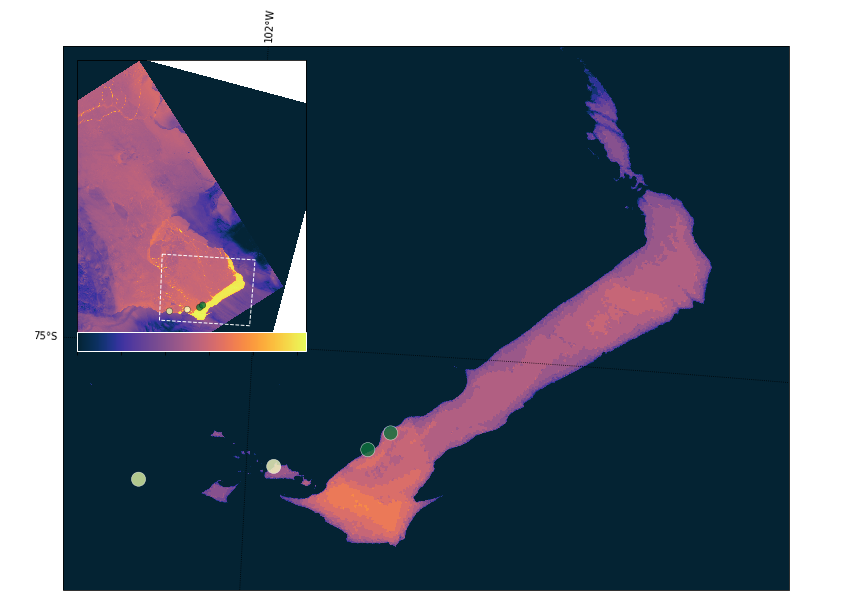

In [12]:
# Plot surface reflectance/temperature
# This takes a little while to run since it's finer spatial resolution imagery (100 m pixels compared to 1 km MODIS pixels for thermal bands)

if vbl=='SA': vmin = 33.8;vmax=34.3
elif vbl=='PD': vmin = 28.4;vmax=29.3
#elif vbl=='CT': vmin = -1.9;vmax=-1.2
#elif vbl=='CT': vmin = -2;vmax=0
elif vbl=='CT': vmin = -2;vmax=-1
    
llcrnrlat=-75.18;urcrnrlat=-74.75;llcrnrlon=-102.6;urcrnrlon=-100.3 # zoom into polynyas/warm T signal

fig,ax = plt.subplots(figsize=(15,10)) # give two axes 

plt.axis('off')
m = plt.axes(projection=ccrs.SouthPolarStereo(central_longitude=-105.0))
m.set_extent([llcrnrlon, urcrnrlon, llcrnrlat, urcrnrlat], ccrs.PlateCarree())
gl = m.gridlines(draw_labels=True,xlocs=[-110,-108,-106,-104,-102,-100],ylocs=[-75,-74,-73,-72,-71],y_inline=False,color='k',linestyle=':')
gl.bottom_labels = gl.right_labels = False

data = m.pcolormesh(LON,LAT,band1,transform=ccrs.PlateCarree(),cmap=cmocean.cm.thermal,vmin=91,vmax=109)

# seal T
dataseal = m.scatter(x,y,c=z,cmap=sealcmap,vmax=vmax,vmin=vmin,edgecolor='w', s= 200,linewidth= 0.5,transform=ccrs.PlateCarree(),zorder=2,alpha=0.8) 

# inset 
axins = inset_axes(ax, width="50%", height="50%", loc='upper left', 
                   axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                   axes_kwargs=dict(map_projection=ccrs.SouthPolarStereo(central_longitude=-105.0)))

ip = InsetPosition(ax,[-0.03, 0.475, 0.5, 0.5])
axins.set_axes_locator(ip)

llcrnrlat=-75.2;urcrnrlat=-73.5;llcrnrlon=-104.7;urcrnrlon=-99.5 # PIG same as seal
axins.set_extent([llcrnrlon, urcrnrlon, llcrnrlat, urcrnrlat], ccrs.PlateCarree())
zoom = axins.pcolormesh(LON,LAT,band1, transform=ccrs.PlateCarree(),cmap=cmocean.cm.thermal,zorder=2)

cax = inset_axes(axins,
                 width="100%",  # width = 10% of parent_bbox width
                 height="7%",  # height : 50%
                 loc='upper left',
                 bbox_to_anchor=(0.0005, -1, 1, 1),
                 bbox_transform=axins.transAxes,
                 borderpad=0,
                 )

# Colorbar
cb = plt.colorbar(zoom,cax=cax,fraction=0.045,pad=0.025,orientation='horizontal')#,shrink=0.84)
cb.ax.tick_params(labelbottom=False)  
cb.outline.set_edgecolor('w')
cb.outline.set_linewidth(1)

dataseal = axins.scatter(x,y,c=z,cmap=sealcmap,vmax=vmax,vmin=vmin,edgecolor='k', s= 40,linewidth= 0.4,transform=ccrs.PlateCarree(),zorder=2,alpha=0.8) 

# bbox
patches = []
zone = np.array([[-102.6,-74.75],[-100.3,-74.75],[-100.3,-75.18],[-102.6,-75.18]])
patches.append(Polygon(zone))
axins.add_collection(PatchCollection(patches, transform=ccrs.PlateCarree(), facecolor = 'none', edgecolor='w', linewidths=1, linestyle='dashed',zorder=3))

plt.savefig('fig3landsat25.jpg', format='jpg', dpi=400)

### 4. Repeat exact same procedure for 27 May 2019

In [13]:
# isolate specific date
may27_2019 = may19[may19['Datetime'].dt.strftime('%Y-%m-%d') == '2019-05-27']
#may25_2019.count()

# keep only surface value
may27_2019 = may27_2019[(may27_2019 ['z']==0.0)]
#may27_2019.count()

In [14]:
# Grid data for plotting 
data1 = may27_2019
data = data1.groupby('Datetime').mean()
data['Max z'] = (data1.groupby('Datetime').max())['z']
vbl = 'CT'
data = data[data[vbl].notna()]
y = data['LATITUDE']
x = data['LONGITUDE']
z = data[vbl]

### 5. Read in coicident thermal image (27 May 2019)

In [13]:
# Make list of all MOD09 files in folder
MODfiles = glob('../MODIS/2019/MOD09.A2019147.1435.006.2019149021710.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)
B31 = (mod09.select('BAND31')[:]/100)-273.15
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

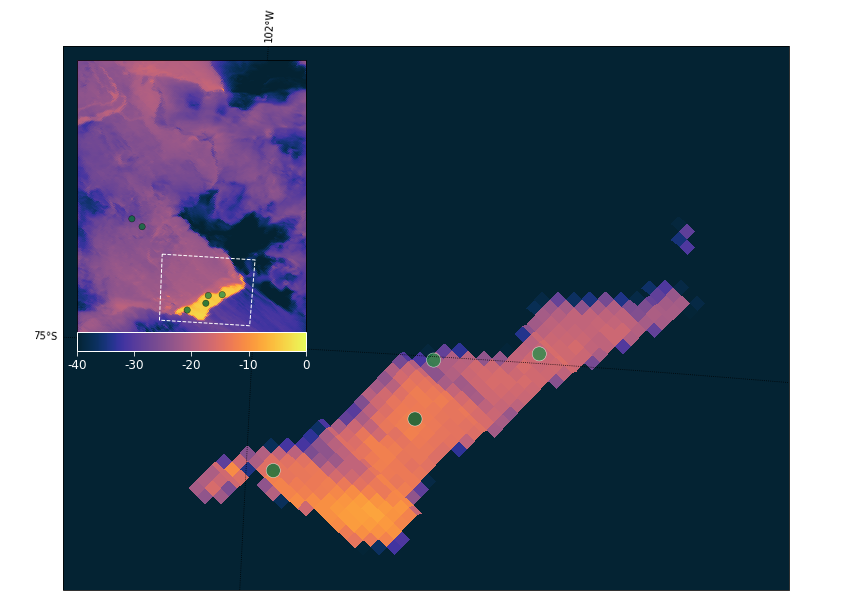

In [16]:
if vbl=='SA': vmin = 33.8;vmax=34.3
elif vbl=='PD': vmin = 28.4;vmax=29.3
#elif vbl=='CT': vmin = -1.9;vmax=-1.2
elif vbl=='CT': vmin = -2;vmax=-1


llcrnrlat=-75.18;urcrnrlat=-74.75;llcrnrlon=-102.6;urcrnrlon=-100.3 # zoom into polynyas/warm T signal

fig,ax = plt.subplots(figsize=(15,10)) # give two axes 

plt.axis('off')
m = plt.axes(projection=ccrs.SouthPolarStereo(central_longitude=-105.0))
m.set_extent([llcrnrlon, urcrnrlon, llcrnrlat, urcrnrlat], ccrs.PlateCarree())
gl = m.gridlines(draw_labels=True,xlocs=[-102,-101.5-101],ylocs=[-75.5,-75,-74.5,-74,-73,-72,-71],y_inline=False,color='k',linestyle=':')
gl.bottom_labels = gl.right_labels  =False

data = m.pcolormesh(lon,lat,B31,transform=ccrs.PlateCarree(),cmap=cmocean.cm.thermal,vmin=-8,vmax=-2)

# seal T
dataseal = m.scatter(x,y,c=z,cmap=sealcmap,vmax=vmax,vmin=vmin,edgecolor='w', s= 200,linewidth= 0.5,transform=ccrs.PlateCarree(),zorder=2,alpha=0.8) 

# inset 
axins = inset_axes(ax, width="50%", height="50%", loc='upper left', 
                   axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                   axes_kwargs=dict(map_projection=ccrs.SouthPolarStereo(central_longitude=-105.0)))

ip = InsetPosition(ax,[-0.03, 0.475, 0.5, 0.5])
axins.set_axes_locator(ip)

llcrnrlat=-75.2;urcrnrlat=-73.5;llcrnrlon=-104.7;urcrnrlon=-99.5 # PIG same as seal
axins.set_extent([llcrnrlon, urcrnrlon, llcrnrlat, urcrnrlat], ccrs.PlateCarree())
zoom = axins.pcolormesh(lon,lat,B31, transform=ccrs.PlateCarree(),cmap=cmocean.cm.thermal,vmin=-40,vmax=0,zorder=2)

cax = inset_axes(axins,
                 width="100%",  # width = 10% of parent_bbox width
                 height="7%",  # height : 50%
                 loc='upper left',
                 bbox_to_anchor=(0.0005, -1, 1, 1),
                 bbox_transform=axins.transAxes,
                 borderpad=0,
                 )

# Colorbar
cb = plt.colorbar(zoom,ticks=[-40,-30,-20,-10,0],cax=cax,fraction=0.045,pad=0.025,orientation='horizontal')#,shrink=0.84)
cb.ax.set_xticklabels([-40,-30,-20,-10,0],color='w')
cb.outline.set_edgecolor('w')
cb.outline.set_linewidth(1)
cb.ax.tick_params(color='w',size=5,labelsize=12)

dataseal = axins.scatter(x,y,c=z,cmap=sealcmap,vmax=vmax,vmin=vmin,edgecolor='k', s= 40,linewidth= 0.4,transform=ccrs.PlateCarree(),zorder=2,alpha=0.8) 
#dataseal = axins.scatter(x,y,c=z,cmap='YlGn',vmax=vmax,vmin=vmin,edgecolor='k', s= 40,linewidth= 0.4,transform=ccrs.PlateCarree(),zorder=2,alpha=0.8) 

# bbox
patches = []
zone = np.array([[-102.6,-74.75],[-100.3,-74.75],[-100.3,-75.18],[-102.6,-75.18]])
patches.append(Polygon(zone))
axins.add_collection(PatchCollection(patches, transform=ccrs.PlateCarree(), facecolor = 'none', edgecolor='w', linewidths=1, linestyle='dashed',zorder=3))

#plt.savefig('fig3modis27.jpg', format='jpg', dpi=400)

## B. Landsat image

### 6. Read in Landsat image

In [17]:
file_name = '../Landsat/LC08_L1GT_157131_20190527_20200828_02_T2_tir.tif'
with rasterio.open(file_name) as src:
    band1 = src.read(1)
    print('Band1 has shape', band1.shape)
    height = band1.shape[0]
    width = band1.shape[1]
    cols, rows = np.meshgrid(np.arange(width), np.arange(height))
    xs, ys = rasterio.transform.xy(src.transform, rows, cols)
    lons= np.array(xs)
    lats = np.array(ys)
    print('lons shape', lons.shape)

Band1 has shape (9141, 9151)
lons shape (9141, 9151)


In [18]:
inProj = Proj(init='epsg:3031') #utm
outProj = Proj(init='epsg:4326') #degrees
LON,LAT = transform(inProj,outProj,lons,lats)

/opt/anaconda3/envs/sealenv/lib/python3.9/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/opt/anaconda3/envs/sealenv/lib/python3.9/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/89/l74gfpqj40z09y2mj3f1sw6h0000gn/T/ipykernel_1048/3143643065.py:3: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrad

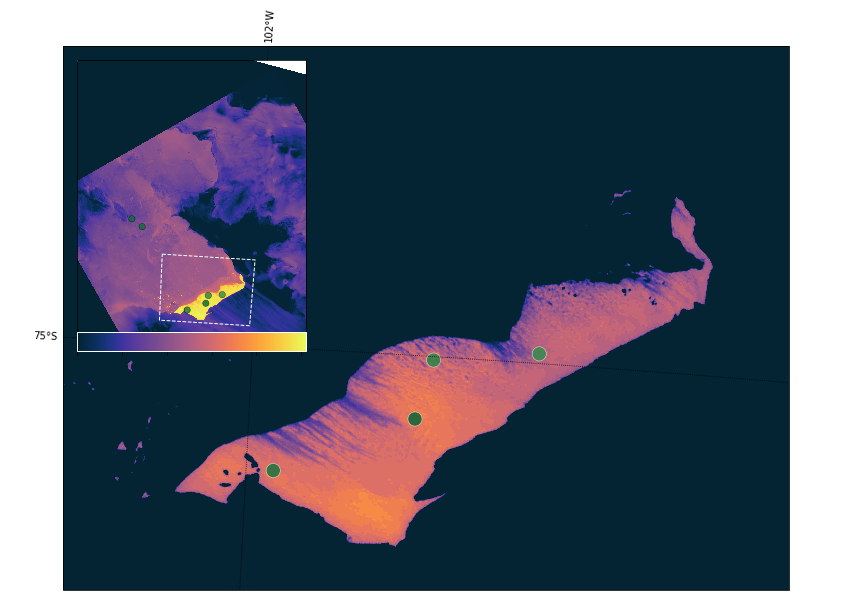

In [20]:
# Plot surface reflectance/temperature
# This takes a little while to run since it's finer spatial resolution imagery (100 m pixels compared to 1 km MODIS pixels for thermal bands)

if vbl=='SA': vmin = 33.8;vmax=34.3
elif vbl=='PD': vmin = 28.4;vmax=29.3
#elif vbl=='CT': vmin = -1.9;vmax=-1.2
#elif vbl=='CT': vmin = -2;vmax=0
elif vbl=='CT': vmin = -2;vmax=-1
    
llcrnrlat=-75.18;urcrnrlat=-74.75;llcrnrlon=-102.6;urcrnrlon=-100.3 # zoom into polynyas/warm T signal

fig,ax = plt.subplots(figsize=(15,10)) # give two axes 

plt.axis('off')
m = plt.axes(projection=ccrs.SouthPolarStereo(central_longitude=-105.0))
m.set_extent([llcrnrlon, urcrnrlon, llcrnrlat, urcrnrlat], ccrs.PlateCarree())
gl = m.gridlines(draw_labels=True,xlocs=[-110,-108,-106,-104,-102,-100],ylocs=[-75,-74,-73,-72,-71],y_inline=False,color='k',linestyle=':')
gl.bottom_labels = gl.right_labels = False

data = m.pcolormesh(LON,LAT,band1,transform=ccrs.PlateCarree(),cmap=cmocean.cm.thermal,vmin=80,vmax=109)

# seal T
dataseal = m.scatter(x,y,c=z,cmap=sealcmap,vmax=vmax,vmin=vmin,edgecolor='w', s= 200,linewidth= 0.5,transform=ccrs.PlateCarree(),zorder=2,alpha=0.8) 

# inset 
axins = inset_axes(ax, width="50%", height="50%", loc='upper left', 
                   axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                   axes_kwargs=dict(map_projection=ccrs.SouthPolarStereo(central_longitude=-105.0)))

ip = InsetPosition(ax,[-0.03, 0.475, 0.5, 0.5])
axins.set_axes_locator(ip)

llcrnrlat=-75.2;urcrnrlat=-73.5;llcrnrlon=-104.7;urcrnrlon=-99.5 # PIG same as seal
axins.set_extent([llcrnrlon, urcrnrlon, llcrnrlat, urcrnrlat], ccrs.PlateCarree())
zoom = axins.pcolormesh(LON,LAT,band1, transform=ccrs.PlateCarree(),cmap=cmocean.cm.thermal,zorder=2)

cax = inset_axes(axins,
                 width="100%",  # width = 10% of parent_bbox width
                 height="7%",  # height : 50%
                 loc='upper left',
                 bbox_to_anchor=(0.0005, -1, 1, 1),
                 bbox_transform=axins.transAxes,
                 borderpad=0,
                 )

# Colorbar
cb = plt.colorbar(zoom,cax=cax,fraction=0.045,pad=0.025,orientation='horizontal')#,shrink=0.84)
cb.ax.tick_params(labelbottom=False)  
cb.outline.set_edgecolor('w')
cb.outline.set_linewidth(1)

dataseal = axins.scatter(x,y,c=z,cmap=sealcmap,vmax=vmax,vmin=vmin,edgecolor='k', s= 40,linewidth= 0.4,transform=ccrs.PlateCarree(),zorder=2,alpha=0.8) 

# bbox
patches = []
zone = np.array([[-102.6,-74.75],[-100.3,-74.75],[-100.3,-75.18],[-102.6,-75.18]])
patches.append(Polygon(zone))
axins.add_collection(PatchCollection(patches, transform=ccrs.PlateCarree(), facecolor = 'none', edgecolor='w', linewidths=1, linestyle='dashed',zorder=3))

plt.savefig('fig3landsat27.jpg', format='jpg', dpi=400)

### 7. I save all panels and format for submission in illustrator or powerpoint :)

Screenshot of Fig. 3 from Savidge et al., 2023:

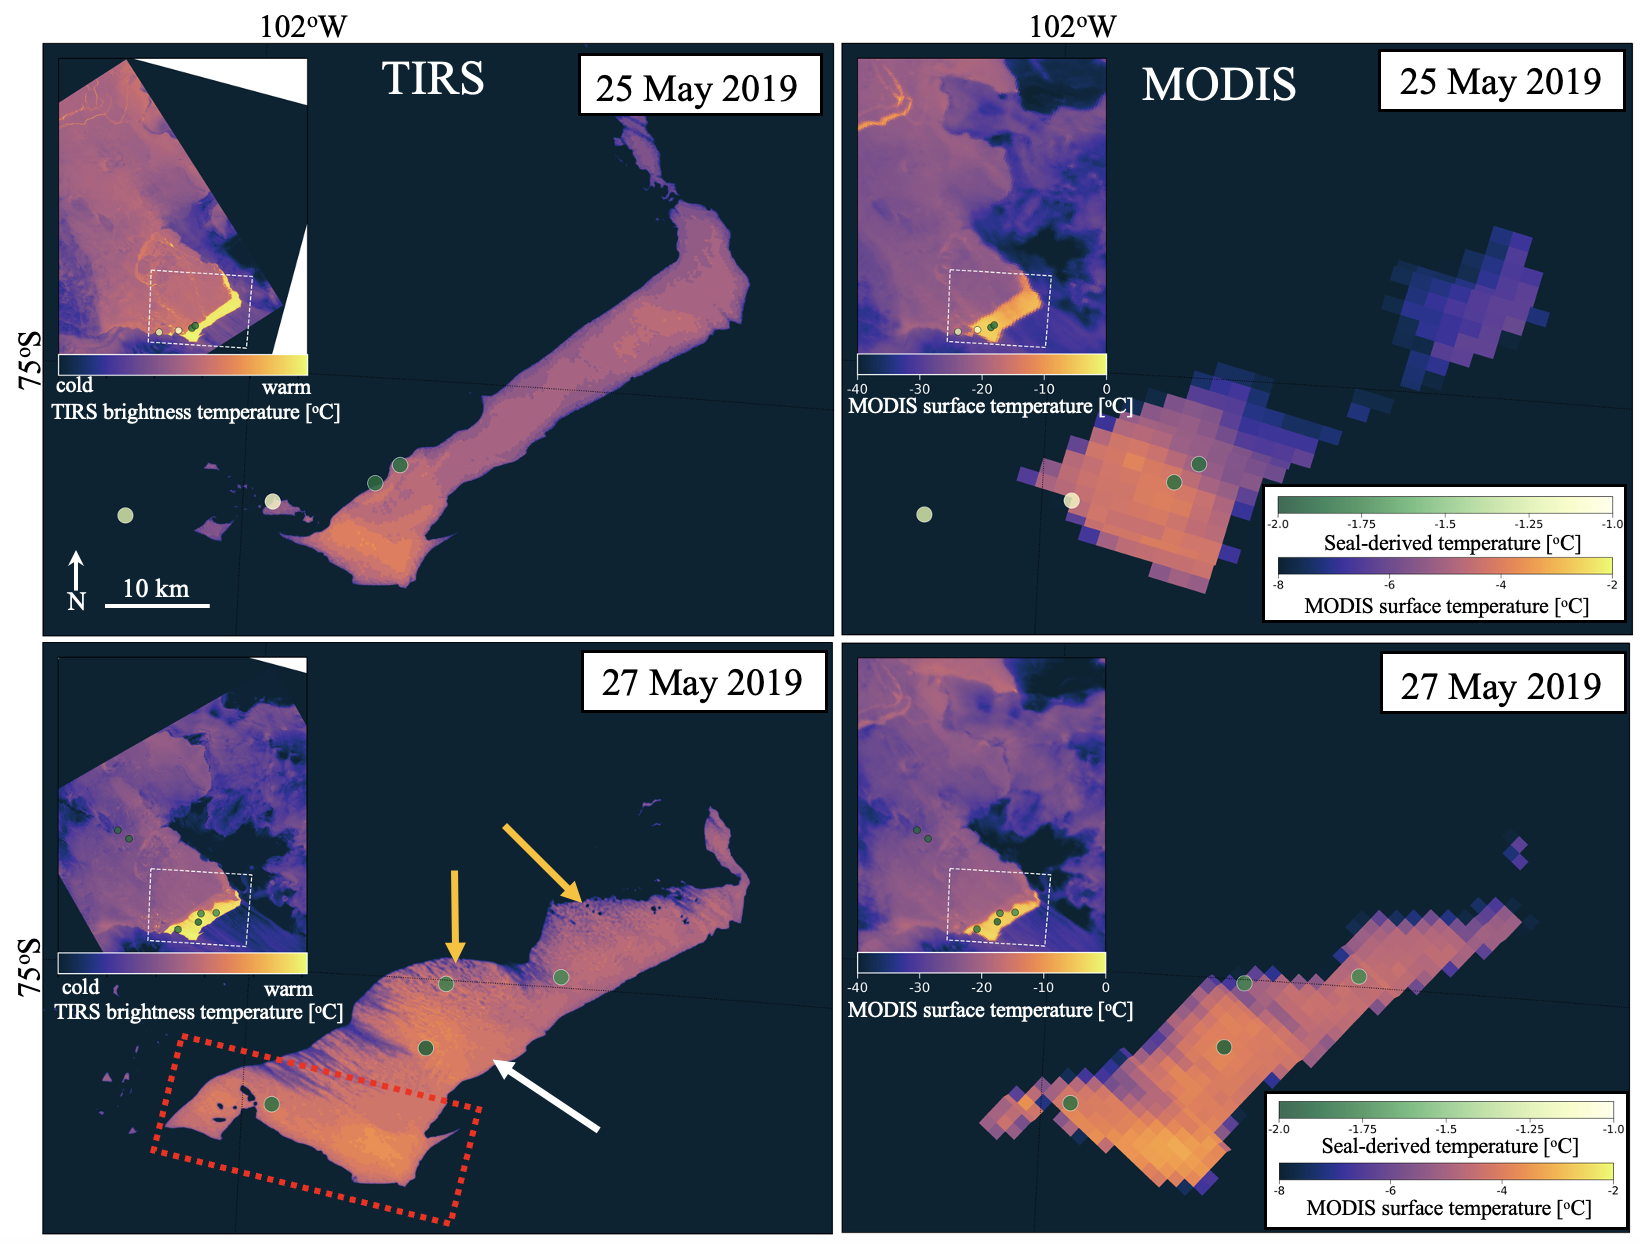

### ~ES